In [1]:
import numpy as np
print("np: ", np.__version__)
import matplotlib
print("mpl: ", matplotlib.__version__)
import numpy as np
import scipy.stats as sst
import scipy as sp
print("sp: ", sp.__version__)
import matplotlib.pylab as plt
import scipy.spatial.distance as ssp
import pandas as pd

from IPython.display import Image
from IPython.display import display
from IPython.display import SVG
from ipywidgets import interact,Checkbox,Text,VBox

import helpers.theo_variogram_fct as vario

import datetime
import helpers.kriging as kri
import helpers.variogram as variokri

np:  1.16.5
mpl:  3.1.1
sp:  1.3.1


In [2]:
#import data iron concentration
data = pd.read_csv("data_iquique/data_fe.csv")
xyz = data.to_numpy()
#print(xyz[:3])

#reduce coordenate numbers
xyz[:,0]= xyz[:,0] - min(xyz[:,0])
xyz[:,1]= xyz[:,1] - min(xyz[:,1])
#print(xyz[:3])

#to define grid (to match sample points with each cell of grid)
delta_x = 1000        #meters (it depends on the data set dimensions)
delta_y = delta_x     #meters. To keep square cells

(539, 2)


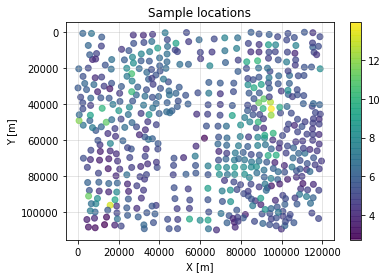

In [3]:
#Scatter plot of samples
xy = xyz[:,0:2] #the coordenate x is the second column and y the first one. 
print(xy.shape)

y = xyz[:,0] #The first coordenate is y rather than x as usual.
x = xyz[:,1]
z = xyz[:,2]


plt.scatter(x, y, c=z, alpha=0.7)
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.colorbar()
plt.title('Sample locations')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True, alpha=0.4)

539
328


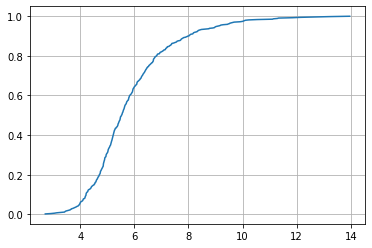

In [4]:
#Calculates the cummulative distribution function of data z
def function_cdf(z):
    s = np.sort(z)
    z_values = np.unique(s)
    pdf = []
    for i in range(len(z_values)-1):
        pdf.append(len(z[(s >= z_values[i]) & (s < z_values[i+1])])/len(s))
    cdf = np.cumsum(pdf)
    cdf = np.append(cdf,1)
    return z_values, cdf

values_cdf, cdf = function_cdf(z)

print(z.size)
print(values_cdf.size)

#Original data
plt.figure()
plt.grid()
plt.plot(values_cdf, cdf)

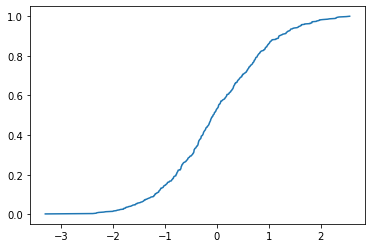

In [5]:
#Data to be transformed
normal_data = np.array(np.random.normal(0,1,len(z)))
values_cdf_normal, cdf_normal = function_cdf(normal_data)

plt.figure()
plt.plot(values_cdf_normal, cdf_normal)

In [6]:
#Normalization of data z
#NOTE: DUE TO ASSIGNATION OF NEW VALUES TO z variable at the end of this cell-code, from the second execution this cell-code doesnt work properly.
#      To fix it run again the cell above to reset values of "z".
norm_z = []
for value in z:
    pos = np.where(values_cdf==value)[0][0]                        #finds cummulative probability of the value
    inter = sp.interpolate.interp1d(cdf_normal,values_cdf_normal)  #To make it continous
    norm_z.append(inter(cdf[pos]))                                 #looks for the normed value with the same cumm probability
norm_z = np.array(norm_z)

z_norm = norm_z#We want to continue with this transformed data otherwise comment line!

print('max z normalized value =', max(z))
print('min z normalized value =', min(z))

max z normalized value = 13.96
min z normalized value = 2.71


total number of distances = 144991
max distance = 155400.2 [m]
min distance = 1419.2 [m]
dimensions of D =  (539, 539)


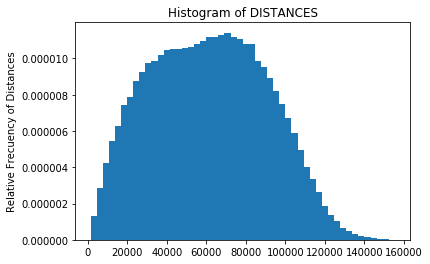

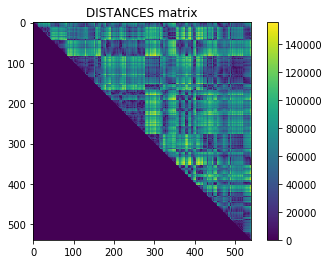

In [7]:
H = ssp.pdist(xy, metric='euclidean')
D = ssp.squareform(H)
upper = np.triu(D)
upper_vector = np.matrix.flatten(upper)
upper_vector = upper_vector[upper_vector>0]
print("total number of distances =", upper_vector.shape[0])
plt.hist(upper_vector, bins = 50, density='true') # bins = np.arange(0, np.round(max(H),0)+1 , delta_x)
plt.title("Histogram of DISTANCES")
plt.ylabel('Relative Frecuency of Distances')
print("max distance =",np.round(max(H),1),"[m]")
print("min distance =",np.round(min(H),1),"[m]")
print("dimensions of D = ",upper.shape)
plt.show()

plt.imshow(upper)
plt.title("DISTANCES matrix")
plt.colorbar()

### Correlogram

In [8]:
n = np.linspace(1000,40000,40)
bins = np.array(n)
print(bins)
print(type(bins))

[ 1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000. 10000.
 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000. 20000.
 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000. 30000.
 31000. 32000. 33000. 34000. 35000. 36000. 37000. 38000. 39000. 40000.]
<class 'numpy.ndarray'>


In [9]:
ixs = []    # for measurement values at point 0
ixs_h = []  # for measurement values at point 1
rs = []     # for rs in each bin
d_mean = [] # for mean distances

ix = np.array(np.where(np.logical_and(D>bins[0], D<=bins[1])))
print(ix.shape)

(2, 26)


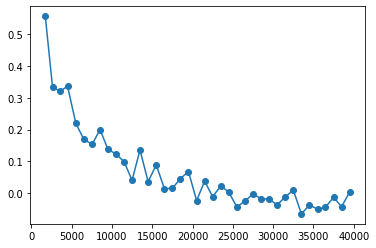

In [10]:
F = z_norm

for cur_i in range(0, len(bins)-1):
    ix = np.where(np.logical_and(D>bins[cur_i], D<=bins[cur_i+1]))
    d_mean.append(D[ix].mean())
    F_0 = F[ix[0]]
    F_1 = F[ix[1]]
    r = np.corrcoef(F_0, F_1)[1,0]
    rs.append(r)
    ixs.append(F_0)
    ixs_h.append(F_1)

#plot
plt.plot(d_mean,
         rs,
        'o-')

### Empiric Variogram

In [11]:
Z1, Z2 = np.meshgrid(F, F)
sem_var = (Z1-Z2)**2.
sem_vars = []
co_vars = []
sem_vars_v2 = []
n_pts = []

for cur_i_bin, cur_bin in enumerate(bins[:-1]):
    #print cur_i_bin, cur_bin
    ix = np.where(np.logical_and(D>bins[cur_i_bin], D<=bins[cur_i_bin+1]))
#     print len(ix)
#     print "  ", ix[0].shape, ix[0].min(), ix[0].max()
#     print "  ", ix[1].shape, ix[1].min(), ix[1].max()
    
    ## do it via the prepared large matrices
    sem_var_cur = np.sum(sem_var[ix])/(2.0 * ix[0].shape[0])
    #print sem_var_cur
    sem_vars.append(sem_var_cur)
    
    #print"      ",  ix[0].shape[0]
    sem_var_v2 = np.sum((F[ix[1]] - F[ix[0]])**2)/(2.0 * ix[0].shape[0])
    sem_vars_v2.append(sem_var_v2)
    
    mean = F[ix[1]].mean()
    covar = np.sum((F[ix[1]]-mean)* (F[ix[0]]-mean))/( ix[0].shape[0])
    co_vars.append(covar)

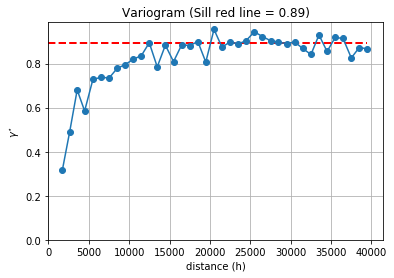

In [12]:
#Sill calculation
sill = np.var(z_norm)  #the sill is the variance of z normalized values
plt.hlines(y=sill, xmin=0, xmax=max(d_mean), colors='r', linestyles='--', lw=2) # plot sill as red dashed line.
plt.plot(d_mean, np.array(sem_vars), marker ='o')                               # plot empirical variogram
plt.grid(True)
plt.title('Variogram (Sill red line = ' + str(np.round(sill,2)) + ')')
plt.xlabel('distance (h)')
plt.ylabel('$\gamma^{\star}$')
plt.xlim(0.0,)
plt.ylim(0.0,)
plt.show()

### Initialize grid and assignation of sample values to proper cells

In [13]:
nx = 2 + int(max(x)/delta_x)       #number of required cells in x-axis
ny = 2 + int(max(y)/delta_y)       #number of required cells in y-axis
print("x max =", max(x), ", y max =", max(y))
print("This map require", nx, "cells in x-axis and", ny,"in y-xis")

x max = 119592.0 , y max = 109987.0
This map require 121 cells in x-axis and 111 in y-xis


In [14]:
#Initialize grid
X,Y = np.mgrid[0:int(delta_y+max(y)):delta_y, 0:int(delta_x+max(x)):delta_x] #is assigned y-related to row and x-related to columns

#Initialize the entire matrix with "None" values
Z = np.zeros([X.shape[0],X.shape[1]])  #it can be with X.shape or Y.shape coz both have same dimensions.
Z[:,:]=None
print('Z dimensions =',Z.shape)

##plot
# plt.imshow(Z, aspect='auto')
# plt.colorbar()
# plt.grid(True)

Z dimensions = (111, 121)


max_z_normal value = 2.5617918326146603
min_z_normal value = -3.3063985704649523


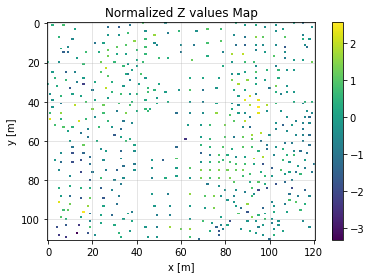

In [15]:
#Assig value of normalized samples (z) to corresponding cells in initialized matrix (Z)

i=0
while i< x.shape[0]:
    x_i = int(np.round(x[i]/delta_x,0))  #return x_i = colum
    y_i = int(np.round(y[i]/delta_y,0))
    Z[y_i][x_i] = z_norm[i]
    i = i+1

print('max_z_normal value =', max(z_norm))
print('min_z_normal value =', min(z_norm))

plt.imshow(Z)
plt.grid(True, alpha=0.4)
plt.imshow(Z, aspect='auto')
plt.colorbar()
plt.title('Normalized Z values Map')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.savefig('sample_grid_map.png', dpi=300) #save a nice .png of this map.

# Theoretical Variogram Models

In [16]:
# Define Dictionaries of Theoretical Variogram Models

# Dictionary for individual variogram models. Reference the theo_variogram_fct python file
models = {'Exponential': vario.ExponentialVariogram,
          'Spherical': vario.SphericalVariogram,
          'Gaussian': vario.GaussianVariogram,
          'Linear': vario.LinearVariogram}

# Dictionary for individual short-form variogram models to be used for composited variogram models
mods = {'Exp': vario.ExponentialVariogram,
        'Sph': vario.SphericalVariogram,
        'Gau': vario.GaussianVariogram,
        'Lin': vario.LinearVariogram}

In [17]:
# plotting for function for individual models
def plot_varmodel(Sill, Range, Model):
    v_model = Model(Sill, Range, h)
    plt.plot(h,v_model, c='red') # Model Variogram
    plt.scatter(d_mean, np.array(sem_vars), s=80) # Empirical Variogram
    plt.xlabel('distance')
    plt.ylabel('$\\gamma$')
    plt.xlim(0.,max(h))
    plt.ylim(0.,)
    plt.grid(True)
    plt.show()

# plotting function for multiple variogram models 
def plot_n_varmodel(Sill, Range):
    for cur_i, var_model in enumerate(var_models):
        v_model = var_model(Sill, Range, h)
        plt.plot(h,v_model, label=models_to_plot[cur_i]) # Model Variogram
        plt.scatter(d_mean, np.array(sem_vars), s=80) # Empirical Variogram
        plt.xlabel('distance')
        plt.ylabel('$\\gamma$')
        plt.xlim(0.,max(h))
        plt.ylim(0.,)
        plt.grid(True)
    plt.legend(loc='best')
    plt.show()

# plotting function for nested models   
def plot_nes_varmodel(h,mod):
    v_model = nest_vario.Variogram(h, model = mod.value)
    plt.plot(h, v_model, c='red') # Model Variogram
    plt.scatter(d_mean, np.array(sem_vars), s=80) # Empirical Variogram
    plt.xlabel('distance')
    plt.ylabel('$\gamma^{\star}$')
    plt.ylim(0.,sum(var_sill)*1.5)
    plt.xlim(0.,max(h))
    plt.grid(True)
    plt.show()

In [18]:
max(d_mean)

39497.25101963115

In [19]:
# Determine first guess of sill and range from empirical variogram
var_sill = np.round(np.max(np.array(sem_vars)),decimals = 2)
h = np.linspace(0, max(d_mean),  int(max(d_mean)/10.))
var_range = np.round(np.max(np.array(d_mean)),decimals = 2)
print(np.max(np.array(sem_vars)))
print(var_sill)

0.9548533997119103
0.95


## Interactive Plot #1

With this interactive display, using slider bars, you can adjust the SILL and the RANGE for a Variogram Model selected from a dropdown list. The graph axes will update automatically.

In [20]:
# Trigger Interactive Plot
# recommended parameters : (sill = 0.9, range = 4740)
import importlib
importlib.reload(vario)
interact(plot_varmodel,
         Sill =(var_sill/100,var_sill*1.5,0.01),
         Range = (0,max(h), max(h)/100),
         Model = models)

interactive(children=(FloatSlider(value=0.7095, description='Sill', max=1.4249999999999998, min=0.0095, step=0…

<function __main__.plot_varmodel(Sill, Range, Model)>

# Interpolate (Kriging)

In [21]:
# number conditioning points
n_cond = 10

# verbose output
talk_to_me = True  # True or False

In [22]:
controls = (np.dstack([x,y]))[0] #return first array of all (x,y) location of sample points.
# print(controls.shape)
# print(controls)

In [23]:
if len(controls.shape)<3: #to avoid in multiple runs add more dimensions
    controls = controls[:, np.newaxis, :] #para que???
# print(len(controls.shape))

In [24]:
x_min = np.min(x)
x_max = np.max(x)
y_min = np.min(y)
y_max = np.max(y)

print(f'x:  min={x_min}, max={x_max}')
print(f'y:  min={y_min}, max={y_max}')

x:  min=0.0, max=119592.0
y:  min=0.0, max=109987.0


In [25]:
xe = np.linspace(start=0, stop=(Z.shape[0]-1)*delta_x, num=(Z.shape[0]))
ye = np.linspace(start=0, stop=(Z.shape[1]-1)*delta_y, num=(Z.shape[1]))
print(xe[:5],xe[-5:])
print(ye[:5],ye[-5:])

xes, yes = np.meshgrid(xe, ye)

# location where to interpolate (x,y values)
target_coords = np.vstack((xes.flatten(),yes.flatten())).T
targets = target_coords
print(targets.shape)

print("Number of cell in meshgrid =",target_coords.shape[0])

[   0. 1000. 2000. 3000. 4000.] [106000. 107000. 108000. 109000. 110000.]
[   0. 1000. 2000. 3000. 4000.] [116000. 117000. 118000. 119000. 120000.]
(13431, 2)
Number of cell in meshgrid = 13431


In [26]:
# measurement values
controlvalues = z_norm
# print(controlvalues.shape)
# print(controls.shape)

In [27]:
var_sample = np.var(controlvalues)
print(var_sample)

0.8927083305261702


In [28]:
# Variogram Parameters
expo = variokri.ExponentialVariogram({'sill': 0.9,
                                   'range': 3740,
                                   'variance': var_sample})

fitted_variogram = variokri.CompositeVariogram()
fitted_variogram.addVariogram(expo)

ok_results = []
ok_result = kri.krige_ok(controls
                       , targets
                       , controlvalues
                       , fitted_variogram
                       , n_cond
                       , verbose = True)
print ('ID \t x \t y \t est(z)')
for i, result in enumerate(ok_result):
    ('{0:2d}\t{1:3.2f}\t{2:3.2f}\t{3:3.2f}'.format(i, targets[i][0], targets[i][1], result[1]))
    # the weights are stored in results[0] but not saved here
    ok_results.append([result[1], result[2]])

ID 	 x 	 y 	 est(z)


In [29]:
print(len(ok_results))

13431


In [30]:
ok_results = np.array(ok_results)
print(ok_results)

[[ 0.24653548  0.69505531]
 [ 0.27327399  0.51413181]
 [ 0.35815595  0.29221469]
 ...
 [-0.3742556   1.09614995]
 [-0.37207992  1.09813118]
 [-0.4371104   1.09681967]]


In [31]:
interpol = ok_results[:,0].reshape((Z.shape[1],Z.shape[0]))
eststd = ok_results[:,1].reshape((Z.shape[1],Z.shape[0]))

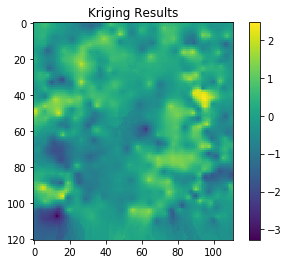

C:\Users\Jimmy\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


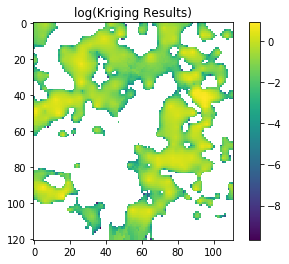

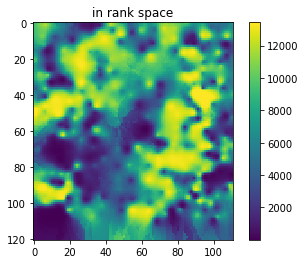

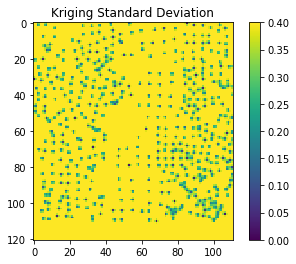

In [34]:
plt.title('Kriging Results')
plt.imshow(interpol,
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('Ordinary Kriging map.png', dpi=300) #save a nice .png of this map.
plt.show()

plt.title('log(Kriging Results)')
plt.imshow(np.log(interpol),
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.

plt.show()

plt.title('in rank space')
plt.imshow(sst.rankdata(interpol.flatten()).reshape(xes.shape[0], xes.shape[1]),
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.

plt.show()

plt.title('Kriging Standard Deviation')
plt.imshow(eststd,
          origin='lower',
          vmin=0.0,
          vmax=0.4)
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('Kriging standar deviation map.png', dpi=300) #save a nice .png of this map.
plt.show()

### Random path function

In [33]:
### EN DESARROLLO!!!

n_sample = 150 #sample amount
A = np.random.rand(nx,ny) #Define nx x ny dimension initial matrix with values in a normal distribution u=0, var=1
sigma = 1 #quizas esto no sea necesario
mu = 0    #quizas esto no sea necesario
print (A.shape)


# fuction to create random vector of sample locations
def random_loc_vec(nx,l): # range of number [0,nx)
    loc_vector = np.random.randint(nx, size=(l,2))
    unique = np.unique(loc_vector, axis=0)
    i=1
    while len(unique) < len(loc_vector) and i<100:     #i is to avoid infinite loop in case.
        dif = len(loc_vector) - len(unique)
        add = np.random.randint(nx, size=(dif,2))
        unique = np.concatenate((unique,add), axis=0)
        unique = np.unique(unique, axis=0)
        i+=1
    unique = np.array(unique)
    return unique

#vector with unique location
location_v= random_loc_vec(nx, n_sample)
print(location_v.shape)


#get global coordenates
coord_xy = np.array(np.zeros((len(location_v),2)))
for i in range(len(location_v)):
    coord_xy[i][0] = location_v[i][0]*delta_x*3/2 
    coord_xy[i][1] = location_v[i][1]*delta_y*3/2
# print(coord_xy[:3])

#Get z values vector
z_values = np.matrix([A[i[0], i[1]] for i in location_v])  #np.matrix to get a matrix transposable
z_values = np.array(z_values.T)

#unify XYZ real world coordenates matrix
xyz= np.concatenate((coord_xy, z_values), axis=1)

(121, 111)
(150, 2)


IndexError: index 118 is out of bounds for axis 1 with size 111